# Description:
This program is for ASTR400B Project.  It will choose a snapshot and bin particles in that snapshot.  It will compare how the particles from each bin are changing during the merger of Andromeda and the Milky Way.  The main focus is to look at the tidal arms and bridges of created and where the particles came from in the merger.  

Authur: Andrew Henrici  
Date last modified: 4/19/2018

In [2]:
%matplotlib notebook
# Import analysis packages
import numpy as np
from scipy import stats
from scipy import interpolate
import astropy.units as u
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import pandas as pd

# Import plotting packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Import my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from RotateFrame import RotateFrame
from Binmaker import binmaker

In [3]:
# Global values

# Comparison radius for n5
ro = 1000

# Define list of colors to cycle through
c = ['b','g','r','c','m','y','k']

In [4]:
# Coordinate Transformations

# Transform from cartesian to 
def cart2sph(self, x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    phi = np.arctan2(z, hxy)
    theta = np.arctan2(y, x)
    return r, theta, phi


def cart2cyl(self, x, y, z):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    z = z
    return rho, theta, z


In [5]:
def nearest_five(data):
    n5 = np.ones((len(data), 5))*r0
    for i in range(len(data)):
        for j in range(len(data)):
            if j != i:
                r = np.sqrt((data[i,0] - data[j,0])**2+(data[i,1] - data[j,1])**2+(data[i,2] - data[j,2])**2)
                for k in range(5):
                    if n5[i,k] == r0 and r<n5[i,k]:
                        n5[i,k] = r
                        break
    return n5

In [6]:
def Find_Local(data, points):
    index = np.zeros(len(data))
    for j in range(len(data)):
        d = data[j]
        delta_r = 1000
        closest_point = 0
        for i in range(len(points)):
            p = points[i]
            r = np.sqrt((d[0]-p[0])**2 + (d[1]-p[1])**2 + (d[2]-p[2])**2)
            if r < delta_r:
                delta_r = r
                closest_point = i
        index[j] = closest_point
    return index

In [7]:
def r_square(data, points, index):
    new_list = np.zeros((len(points),3), dtype = float)
    for i in range(len(points)):
        p = points[i]
        close = data[np.where(index == i)]
        fx, fy, fz = 0, 0, 0
        for c in close:
            fx += c[0]/len(close)
            fy += c[1]/len(close)
            fz += c[2]/len(close)
        new_list[i, 0] = fx
        new_list[i, 1] = fy
        new_list[i, 2] = fz
    return new_list

In [8]:
# From https://stackoverflow.com/questions/24733185/volume-of-convex-hull-with-qhull-from-scipy

def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6

def convex_hull_volume_bis(pts):
    ch = ConvexHull(pts)

    simplices = np.column_stack((np.repeat(ch.vertices[0], ch.nsimplex),
                                 ch.simplices))
    tets = ch.points[simplices]
    return np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1],
                                     tets[:, 2], tets[:, 3]))

In [9]:
def Mean(inputs):
    good_inp = []
    for i in range(len(inputs)):
        if inputs[i] != r0:
            good_inp.append(inputs[i])
    return sum(good_inp)/len(good_inp)

# Part 1:  Set Initial Bins
Use point in time right before collision to mark "original" positions of the particles to track them.  
Will create radial bins and angular bins.  
The current checkpoint is 270

In [10]:
# Call the bin maker to create bins for the checkpoint
B = binmaker("MW_281.txt")

# Decide number of bins
N_Rad = 7
N_Ang = 4

# Create the bins
Radial, rmax = B.Radial_Bins(N_Rad)
Angular = B.Angular_Bins(N_Ang)

print(np.unique(Radial))

[0 1 2 3 4 5 6]


In [ ]:
plt.figure()

plt1=plt.subplot(211)
plt2=plt.subplot(212)
snapshot = 281
# Store the COM of the Milky Way to center on
COMD = CenterOfMass("MW_{}.txt".format(snapshot), 2)
COMP = COMD.COM_P(0.1, 4.0)

# Recenter to COM position
xD = COMD.x - float(COMP[0]/u.kpc)
yD = COMD.y - float(COMP[1]/u.kpc)
zD = COMD.z - float(COMP[2]/u.kpc)

# Store the COM of the Milky Way to center on
COMD = CenterOfMass("MW_{}.txt".format(snapshot+2), 2)
COMP = COMD.COM_P(0.1, 4.0)

# Recenter to COM position
xB = COMD.x - float(COMP[0]/u.kpc)
yB = COMD.y - float(COMP[1]/u.kpc)
zB = COMD.z - float(COMP[2]/u.kpc)

# Convert COM to spherical
for i in range(3, N_Rad):
    index = np.where(Radial == i)
    
    plt1.plot(xD[index], yD[index], '.', color=c[i])
    plt2.plot(xB[index], yB[index], '.', color=c[i])
    
print(np.where(Radial == 6))

In [ ]:
plt.figure()
plt.hist(Radial, log=True, bins=[0,1,2,3,4,5,6,7])

In [ ]:
# Store the COM of the Milky Way to center on
COMD = CenterOfMass("MW_007.txt",2)
COMP = COMD.COM_P(0.1, 4.0)

# Recenter to COM position
xD = COMD.x #- float(COMP[0]/u.kpc)
yD = COMD.y - float(COMP[1]/u.kpc)
zD = COMD.z - float(COMP[2]/u.kpc)

# Plot the particles according to their bins
fig = plt.figure()
for i in range(N_Rad):
    index = np.where(Radial == i)
    plt.plot(xD[index], yD[index], '.', color=c[i])

In [ ]:
ro = np.linspace(0, rmax, 100)


    
# Data
x=range(1,6)
y=[]

# Plot
plt.figure()
plt.stackplot(x,y, labels=['A','B','C'])
plt.legend(loc='upper left')
plt.show()

In [ ]:
fig = plt.figure()

# plot the cuts

plt.xlim(-100.,100.)
plt.ylim(-100.,100.)

X = np.linspace(-100., 100., 100)
plt.plot(X, -40.*np.sin((X-30.)/50.), '--')
plt.plot(X, -40.*np.sin(X/50.), '--')
plt.plot(X, -40.*np.sin((X+30.)/50.), '--')

lower_index = np.where(yD <= -40.*np.sin((xD+30)/50))
upper_index = np.where(yD >= -40.*np.sin((xD-30.)/50.))

xl, yl, zl = xD[lower_index], yD[lower_index], zD[lower_index]
xu, yu, zu = xD[upper_index], yD[upper_index], zD[upper_index]

plt.plot(xu, yu, ',')
plt.plot(xl, yl, ',')


In [ ]:
fig = plt.figure()

test_points = np.array([[17, 10, 0],
                        [18, 25, 0],
                        [4, 38, -2],
                        [-12, 40, -6],
                        [-22, 38, -10]])

plt.plot(xu, yu, ',')
plt.plot(test_points[:,0], test_points[:,1])

tck, _u = interpolate.splprep([test_points[:,0], test_points[:,1], test_points[:, 2]], s=0)
unew = np.linspace(0, 1.01, 8)
out = interpolate.splev(unew, tck)
plt.plot(out[0], out[1])

In [ ]:
data = np.transpose(np.array([xu, yu, zu]))
path = np.transpose(out)
index = Find_Local(data, path)
new_list = r_square(data, path, index)
index = Find_Local(data, new_list)

In [ ]:
plt.figure()
for i in range(8):
    p1 = data[np.where(index == i)]
    plt.plot(p1[:,0], p1[:,1],',', alpha =0.2)

In [ ]:
index = Find_Local(data, new_list)

volume = np.zeros(len(new_list))

for i in range(len(test_points)):
    p1 = data[np.where(index == i)]
    
    volume[i] = convex_hull_volume_bis(p1)
   

In [ ]:
plt.figure()
x_pos = []
t = np.linspace(0,800,801)
for i in t:
    # Store the COM of the Milky Way to center on
    snapshot = "{:03d}".format(int(i))
    print(snapshot)
    COMD = CenterOfMass("MW_{}.txt".format(snapshot), 2)
    COMP = COMD.COM_P(0.1, 4.0)
    
    # Recenter to COM position
    xD = COMD.x - float(COMP[0]/u.kpc)
    yD = COMD.y - float(COMP[1]/u.kpc)
    zD = COMD.z - float(COMP[2]/u.kpc)
    
    r = np.sqrt(xD[2313]**2 + yD[2313]**2 + zD[2313]**2)
    x_pos.append(r)

plt.plot(t, x_pos)

<IPython.core.display.Javascript object>


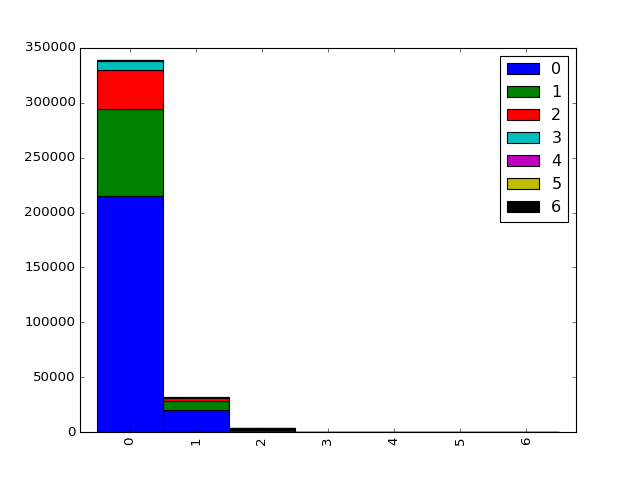

<IPython.core.display.Javascript object>


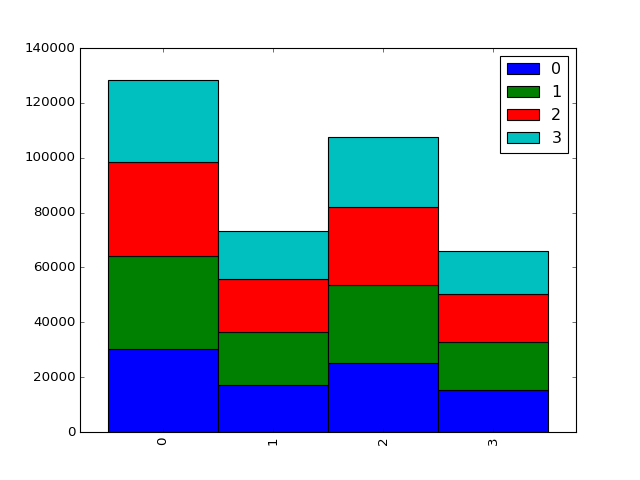

        0      1      2     3    4   5  6
0  215409  78774  35718  8659  710  24  1
1   20305   7622   3300   818   44   0  0
2    2198    793    392   108    5   1  0
3      53     16      9     3    0   0  0
4      21      7      2     0    0   0  0
5       4      2      1     0    0   0  0
6       0      1      0     0    0   0  0


In [29]:

# Decide number of bins
N_Rad = 7
N_Ang = 4

rad = np.zeros((N_Rad, N_Rad))
ang = np.zeros((N_Ang, N_Ang))
# Call the bin maker to create bins for the checkpoint
B = binmaker("MW_001.txt")


# Create the bins
Radial0, rmax = B.Radial_Bins(N_Rad)
Angular0 = B.Angular_Bins(N_Ang)

# Call the bin maker to create bins for the checkpoint
A = binmaker("MW_702.txt")

# Create the bins
Radialf, rmax = A.Radial_Bins(N_Rad)
Angularf = A.Angular_Bins(N_Ang)

for i in range(N_Rad):
    for j in range(N_Rad):
        rad[i,j] = len(np.where((Radial0 == i) & (Radialf == j))[0])
        

for i in range(N_Ang):
    for j in range(N_Ang):
        ang[i,j] = len(np.where((Angular0 == i) & (Angularf == j))[0])
        

Rad = pd.DataFrame(rad.transpose())
Rad.plot.bar(stacked=True, width=1)
Ang = pd.DataFrame(ang.transpose())
Ang.plot.bar(stacked=True, width=1)
print(Rad)

<IPython.core.display.Javascript object>

0


<IPython.core.display.Javascript object>


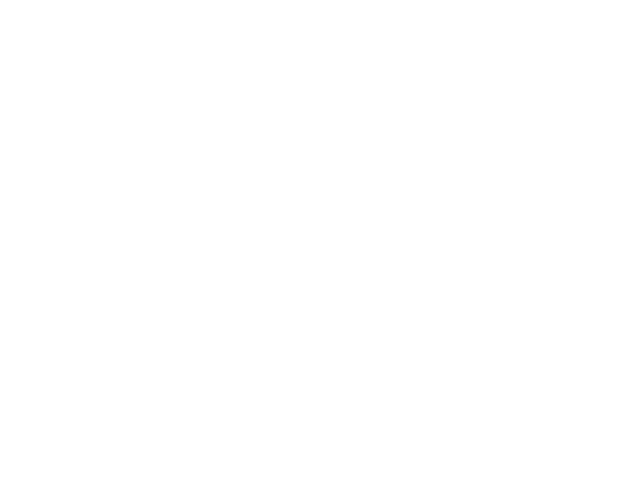

1


<IPython.core.display.Javascript object>


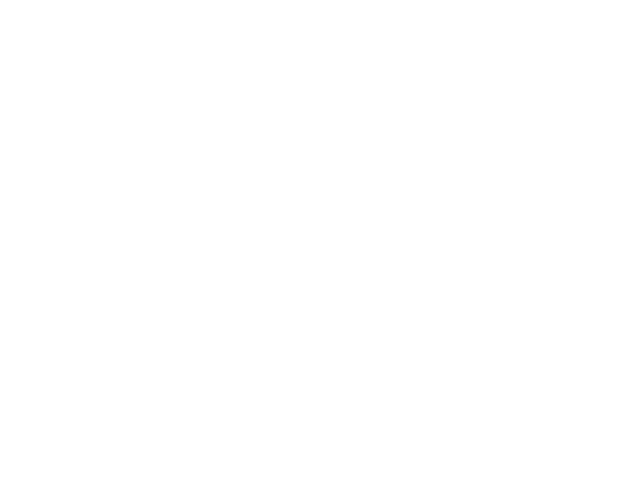

2


<IPython.core.display.Javascript object>


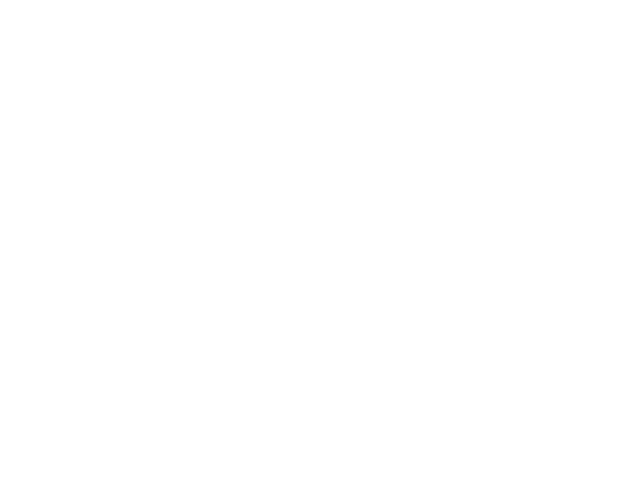

3


<IPython.core.display.Javascript object>


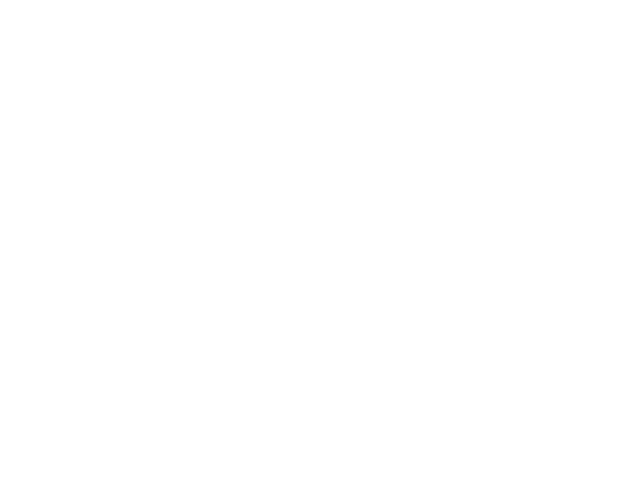

4


<IPython.core.display.Javascript object>


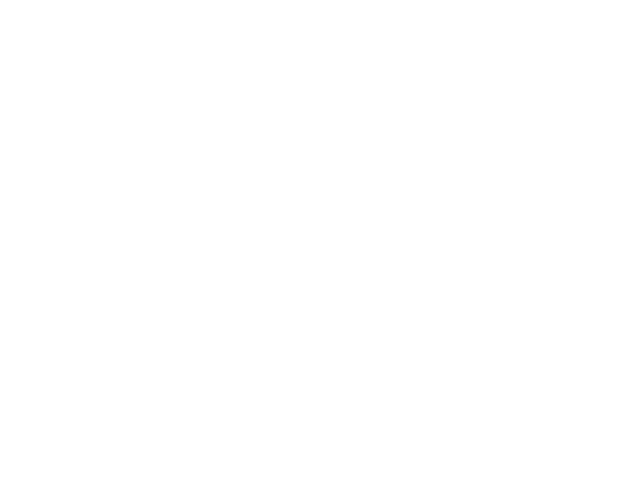

5


<IPython.core.display.Javascript object>


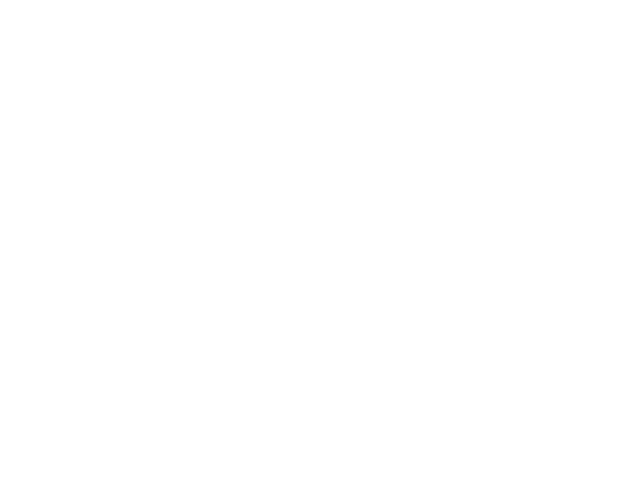

6


In [ ]:
plt.figure()

# Decide number of bins
N_Rad = 7
N_Ang = 4

# Call the bin maker to create bins for the checkpoint
B = binmaker("MW_001.txt")


# Create the bins
Radial0, rmax = B.Radial_Bins(N_Rad)
Angular0 = B.Angular_Bins(N_Ang)

for t in range(801):
    print(t)
    
    rad = np.zeros((N_Rad, N_Rad))
    ang = np.zeros((N_Ang, N_Ang))
    

    # Call the bin maker to create bins for the checkpoint
    A = binmaker("MW_{:03d}.txt".format(t))

    # Create the bins
    Radialf, rmax = A.Radial_Bins(N_Rad)
    Angularf = A.Angular_Bins(N_Ang)

    for i in range(N_Rad):
        for j in range(N_Rad):
            rad[i,j] = len(np.where((Radial0 == i) & (Radialf == j))[0])


    for i in range(N_Ang):
        for j in range(N_Ang):
            ang[i,j] = len(np.where((Angular0 == i) & (Angularf == j))[0])


    Rad = pd.DataFrame(rad.transpose())
    Rad.plot.bar(stacked=True, width=1)
    
    plt.savefig("MW_001-{:03d}.png".format(t))
    plt.title("t = {:03d}".format(t))
    plt.close()